# Compressing bit strings in qubits using superposition effect

### Contributors
[Łukasz Herok](http://lukaszherok.com)

This tutorial is based upon the "Comparing Strings with Quantum Superposition" tutorial by Rudy Raymond.


## Motivation

The aim of this tutorial is to show you how quantum computers can store information encoded in a bit string using  significantly fewer qubits than classical bits. It is possible thanks to **the superposition effect**. I will try to explain it through the example.

This tutorial is designed to be an independent teaching material, so in the firsts sections  it repeats the basics that can be found in the other resources to make it easier to understand the final concept. If you are familiar with basics quantum computing rules you can just skip to the [Compressing bit strings in qubits using the superposition effect](#compressing) section.


In [1]:
# Import of the modules and initialization of variables used in this tutorial
import numpy as np
import qiskit
from qiskit import BasicAer as Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute
import math
from qiskit.tools.visualization import plot_histogram

# qiskit.IBMQ.load_accounts()
backend = Aer.get_backend('qasm_simulator')
backend_vec= Aer.get_backend('statevector_simulator')

## Bit vs Qubit

The computer bit can store and manipulate the two states `0` and `1`. These two states map to the two qubit  basis (orthonormal) states:


$ \left| 0 \right\rangle = {\begin{bmatrix}1 \\ 0\end{bmatrix}} $,

$ \left| 1 \right\rangle = {\begin{bmatrix}0 \\ 1\end{bmatrix}} $.

In fact, the qubit state is represented by the linear *superposition* of these two basics states

$ \left| q \right\rangle = \alpha \left|0\right\rangle + \beta \left|1\right\rangle $
so we can write
$ \left|q\right\rangle = {\begin{bmatrix}\alpha \\ 0\end{bmatrix}} +  {\begin{bmatrix}0 \\ \beta \end{bmatrix}} =  {\begin{bmatrix} \alpha \\ \beta \end{bmatrix}} $. 

The $ \alpha $ and $ \beta $ are the probability amplitudes and are the complex numbers. The formula $|\alpha|^2$ tells us about the probability that the qubit is in state $\left| 0 \right\rangle$. So these coefficients have to meet the normalization requirement $|\alpha|^2 + |\beta|^2  = 1$ to have the overall probability equals to one.

So, as we can see a qubit can exist in a *superposition* of states. By the measurement, we can only check the probability of each state the qubit can take. For the quantum computing, besides the basis states $\left| 0 \right\rangle$, $\left| 1 \right\rangle$, we often encounter the superposition states marked by $\left| + \right\rangle$, $\left| - \right\rangle$. In these states there is the equal probability ($|\alpha|^2$ = 0.5 and $|\beta|^2 = 0.5 $) that the qubit is in one of the basis states $\left| 0 \right\rangle$ or $\left| 1 \right\rangle$. Any state for which both $\alpha$ and $\beta$ are non-zero is called a superposition state. There are also the mixed states which cannot be described with a single ket vector but instead, need matrices. 
We can switch a qubit into the superposition state from $\left| 0 \right\rangle$ to $\left| + \right\rangle$ and back to $\left| 0 \right\rangle$ using the *Hadamard gate*. There is no similar operation available for bits as they operate only over two states `0,1`.

### Math
The Hadamard gate is represented by the matrix: 

$H =  \frac{1}{\sqrt{2}} {\begin{bmatrix}1 & 1\\1 & -1\end{bmatrix}} $.

To create a superposition state from the $\left| 0 \right\rangle$, we need to multiply the matrices:

$ H\left| 0 \right\rangle 
= \frac{1}{\sqrt{2}} {\begin{bmatrix}1 & 1\\1 & -1\end{bmatrix}} {\begin{bmatrix}1 \\0\end{bmatrix}} 
= \frac{1}{\sqrt{2}} {\begin{bmatrix}1\cdot1 + 1\cdot0 \\ 1\cdot1 -1\cdot0\end{bmatrix}}
=  {\begin{bmatrix}0,7071 \\ 0,7071\end{bmatrix}}
= \left| + \right\rangle
$,

so $\alpha = 0.7071$, and $\beta = 0.7071$. Making a square of these we can get $0.5$ probability that the qubit is in state $\left| 0 \right\rangle$ and $0.5$ that it is in state $\left| 1 \right\rangle$.

We can, of course, go back to the $\left| 0 \right\rangle$ state using the Hadamard gate again:

$ H\left| + \right\rangle
= \frac{1}{\sqrt{2}} {\begin{bmatrix}1 & 1\\1 & -1\end{bmatrix}} {\begin{bmatrix}\frac{1}{\sqrt{2}}  \\\frac{1}{\sqrt{2}} \end{bmatrix}} 
= {\begin{bmatrix}1 \\ 0\end{bmatrix}}
= \left| 0 \right\rangle
$


### Numeric

In [2]:
# |0>
Zero = np.array([[1.],
                 [0.]]) 

H = 1./np.sqrt(2) * np.array([[1, 1],
                              [1, -1]])

print("Initial state |0> \n %s " % Zero)

Sup = np.dot(H, Zero)
print("\n H|0> = |+> \n %s" % Sup)

Back = np.dot(H, Sup)
print("\n H|+> = |0> \n %s" % Back)


Initial state |0> 
 [[1.]
 [0.]] 

 H|0> = |+> 
 [[0.70710678]
 [0.70710678]]

 H|+> = |0> 
 [[1.]
 [0.]]


### Quantum

In [3]:
q1 = QuantumRegister(1) # Qubit in the |0> state.
circ = QuantumCircuit(q1) # Circuit represents a quantum program.

circ.h(q1) # H|0>

print(circ)

         ┌───┐
q0_0: |0>┤ H ├
         └───┘


In [4]:
# To get final results from the qubit we need a classical register to store measurements
c1 = ClassicalRegister(1) 
circ.add_register(c1)
circ.measure(q1, c1)

result = execute(circ, backend=backend, shots=1024).result()
print(result.get_counts())

{'0': 529, '1': 495}


Analyzing the result of the quantum program, we can see how many times the states $\left| 1 \right\rangle$ and $\left| 0 \right\rangle$ were measured. We can see that both states were measured almost the same number of times.

Let's check if using two H gates will bring us to the initial state:

In [5]:
circ = QuantumCircuit(q1)

circ.h(q1) # H|0>
circ.h(q1) # H|+>

print(circ)

         ┌───┐┌───┐
q0_0: |0>┤ H ├┤ H ├
         └───┘└───┘


In [6]:
circ.add_register(c1)
circ.measure(q1, c1)

result = execute(circ, backend=backend, shots=1024).result()
print(result.get_counts())

{'0': 1024}


this time only the $\left| 0 \right\rangle$ state was measured. So the qubit is back in the $\left| 0 \right\rangle$ state.

For the classical bit there is no possibility to switch it into a *mixed state* and go back to the original state. That gives us a clue that in the quantum computer we gain a possibility to use more states using fewer resources to perform algorithms.

## Bit flip

Before going further we will get to know one more gate to catch better the idea of qubits manipulation. The *Pauli-X gate* changes the state from $\left| 0 \right\rangle$ to $\left| 1 \right\rangle$. Its counterpart in the classical computers is the NOT logic gate.

$ X = {\begin{bmatrix}0 & 1\\1 & 0\end{bmatrix}} $,


### Math

$ X\left| 0 \right\rangle = {\begin{bmatrix}0 & 1\\1 & 0\end{bmatrix}} {\begin{bmatrix}1 \\ 0\end{bmatrix}} = {\begin{bmatrix}0 \\ 1 \end{bmatrix}} = \left| 1 \right\rangle$,


### Numeric

In [7]:
X = np.array([[0, 1],
              [1, 0]])

np.dot(X, Zero)

array([[0.],
       [1.]])

### Quantum

In [8]:
circ = QuantumCircuit(q1)
circ.x(q1)
print(circ)

         ┌───┐
q0_0: |0>┤ X ├
         └───┘


In [9]:
circ.add_register(c1)
circ.measure(q1, c1)

result = execute(circ, backend=backend_vec).result()
print(result.get_counts())
print(result.get_statevector())

{'1': 1}
[0.+0.j 1.+0.j]


## Making the qubytes

To store more information we can combine multiple qubits creating qubytes. It's the same what we do with bits. But, as you will see, the same size of qubyte can store lots of more information than a byte.

Using two qubits we can build states like: $\left| 00 \right\rangle$, $\left| 10 \right\rangle$, $\left| 0+ \right\rangle$, etc. To do that we make a tensor product of two qubits.

### Math

$ \left| 01 \right\rangle = \left| 0 \right\rangle \otimes \left| 1 \right\rangle 
= {\begin{bmatrix}1 \\ 0\end{bmatrix}} \otimes {\begin{bmatrix}0 \\ 1\end{bmatrix}} 
= {\begin{bmatrix}1 \\ 0\end{bmatrix}}  {\begin{bmatrix}0 \\ 1\end{bmatrix}}^{T}
= {\begin{bmatrix}1 \\ 0\end{bmatrix}} {\begin{bmatrix}0 & 1\end{bmatrix}}
= {\begin{bmatrix}0\\ 1 \\ 0 \\ 0\end{bmatrix}} 
$


### Numeric

In [10]:
One = np.array([[0.],
                [1.]]) 

# Tensor product (Kronecker prodcut in numpy)
np.kron(Zero, One)

array([[0.],
       [1.],
       [0.],
       [0.]])

### Quantum

In [11]:
q2 = QuantumRegister(2) # |00>
circ = QuantumCircuit(q2)
circ.x(q2[0]) # bit filp on a first qubit (right to left - little endian)

print(circ)

         ┌───┐
q1_0: |0>┤ X ├
         └───┘
q1_1: |0>─────
              


In [12]:
# Add measurement & Run
c2 = ClassicalRegister(2)
circ.add_register(c2)
circ.measure(q2, c2)
result = execute(circ, backend=backend_vec).result()

print(result.get_counts())
print(result.get_statevector())

{'01': 1}
[0.+0.j 1.+0.j 0.+0.j 0.+0.j]


Initializing more complex states could be tedious task, so for that purpose we can also use a `initialize()`  function which will prepare the appropriate gates set for us:

In [13]:
circ = QuantumCircuit(q2)
circ.initialize([0., 1, 0, 0.], q2)

print(circ)


         ┌───┐┌────────────┐┌───┐┌────────────┐
q1_0: |0>┤ X ├┤ Ry(1.5708) ├┤ X ├┤ Ry(1.5708) ├
         └─┬─┘└────────────┘└─┬─┘└────────────┘
q1_1: |0>──■──────────────────■────────────────
                                               


We can see that it used CNOT and Ry gates, but the effect is the same:

In [14]:
c2 = ClassicalRegister(2)
circ.add_register(c2)
circ.measure(q2, c2)
result = execute(circ, backend=backend).result()

print(result.get_counts())

{'01': 1024}


The `initialize()` function implements a recursive initialization algorithm according to ["Synthesis of Quantum Logic Circuits" Shende, Bullock, Markov](https://arxiv.org/abs/quant-ph/0406176v5).

<a id='compressing'></a>
## Compressing bit strings in qubits using the superposition effect

In this section, we will try to save bit string `1001` in the quantum chip, and read it back. In this case, the advantage of using qubits instead of bits is not surprising, but working on the short string will be much easier to catch the concept.


To store a bit string: `1001` in a classical computer we will need to use 4 bits.
For the same purpose, in a quantum computer it is enough to use only 3 qubits. To take advantage of the quantum computer advantage we need to use a notation which will allow us to **store multiple states in the qubyte**. That's the thing that is impossible on classical computers. The way for that is to write down the bit string in the notation where firsts qubits describe the position (address) in a bit string, and the last one, the value on this position. For our `1001` it will be:

```
   bs | aa v 
  ----|------- 
    1 | 00 1  # the first position  (00) holds 1
    0 | 01 0  # the second position (01) holds 0
    0 | 10 0
    1 | 11 1   
```

The first two qubits `aa` will be storing the address, and the third qubit `v` the value under this address. We will hold the information in a quantum chip for every of the **four address-value information at the same time**. That would be impossible using this notation and the bits because then at the same time we can address only one position of the bit string in the computer's memory.
Looking at the table above we see that we need three qubits (`aav`) to store information about four states ($\left| 001 \right\rangle$, $\left| 010 \right\rangle$, $\left| 100 \right\rangle$, $\left| 111 \right\rangle$) that describe the bit string. The listed states will be encoded in the quantum chip with the same probability:

$\left| bs \right\rangle = \alpha \left| 001 \right\rangle + \alpha \left| 010 \right\rangle + \alpha\left| 100 \right\rangle + \alpha\left| 111 \right\rangle$

The other states that do not occur (eg. $\left| 000 \right\rangle$) get the amplitude equals to 0 ($\beta = 0$). We can write the full quantum state:

$|bs> = \beta \left| 000 \right\rangle + \alpha \left| 001 \right\rangle + \alpha \left| 010 \right\rangle + \beta \left| 011 \right\rangle + \alpha\left| 100 \right\rangle + \beta \left| 101 \right\rangle + \beta \left| 110 \right\rangle + \alpha\left| 111 \right\rangle$

as the $\alpha$ needs to meet the normalization constraint in our case should be equal to $\frac{1}{2}$.

Summarizing, using the quantum gates we need to set up our system in that way, that after the measurement it will return only the states $\left| 001 \right\rangle$, $\left| 010 \right\rangle$, $\left| 100 \right\rangle$, $\left| 111 \right\rangle$  with similar probability.

In [15]:
q3 = QuantumRegister(3)
c3 = ClassicalRegister(3)
circ = QuantumCircuit(q3, c3)

alpha = .5
beta = .0
circ.initialize([beta, alpha, alpha, beta, alpha, beta, beta, alpha], q3)

print(circ)

                                     ┌───┐┌───┐┌────────────┐┌───┐┌───┐»
q2_0: |0>────────────────────────────┤ X ├┤ X ├┤ Ry(1.5708) ├┤ X ├┤ X ├»
                       ┌────────────┐└─┬─┘└─┬─┘└────────────┘└─┬─┘└─┬─┘»
q2_1: |0>──────────────┤ Ry(1.5708) ├──┼────■──────────────────┼────■──»
         ┌────────────┐└────────────┘  │                       │       »
q2_2: |0>┤ Ry(1.5708) ├────────────────■───────────────────────■───────»
         └────────────┘                                                »
 c3_0: 0 ══════════════════════════════════════════════════════════════»
                                                                       »
 c3_1: 0 ══════════════════════════════════════════════════════════════»
                                                                       »
 c3_2: 0 ══════════════════════════════════════════════════════════════»
                                                                       »
«      ┌────────────┐┌───┐┌───┐┌───┐┌───┐
«q2_0: ┤ 

Above we can see a composition of quantum gates that are required to setup up qubits to represent our bit string. To check if the sequence is really making our bit string we have to add measurement at the and of the circuit and run the quantum program (the quantum circuit):

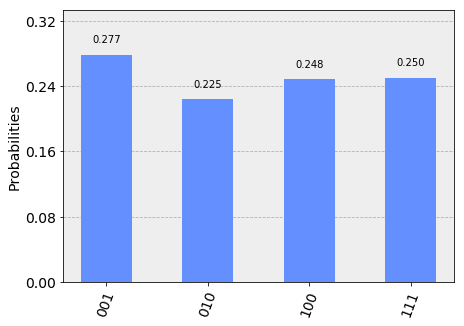

In [16]:
# Run & plot
circ.measure(q3, c3)
job = execute(circ , backend=backend)
st = job.result().get_counts()
plot_histogram(st)


Running the quantum circuit, that encodes a bit string, gives us as feedback information on how many times the specific state was counted. Basing on this we can recalculate the probability, that is shown on the chart.

Looking at the chart we see that it was measured that state $\left| 001 \right\rangle$ exists with probability around $0.2$. The lack of the $\left| 000 \right\rangle$ state means that it didn't occur. It makes us sure that on the position `00` in a bit string there should be `1`.

In real life, imperfections happen. So you could use the probability to resolve ambiguities: if you find both `000` and `001` in your results, accept the most probable and reject the other as noise.

### Compression effectivity

The example a for four-length bit string is good for the step by step explanation but doesn't show the real power of quantum computing. Making the bit string longer shows clearer the advantage of the superposition effect:

In [17]:
for i in [4, 8, 16, 32, 256, 1024, 1024*1024, 1024*1024*1024]:
    n = math.ceil(math.log2(i)) + 1
    print("qubits %s, \t bits: %s" % (n, i))


qubits 3, 	 bits: 4
qubits 4, 	 bits: 8
qubits 5, 	 bits: 16
qubits 6, 	 bits: 32
qubits 9, 	 bits: 256
qubits 11, 	 bits: 1024
qubits 21, 	 bits: 1048576
qubits 31, 	 bits: 1073741824


We have to have in mind that this compression comes at a price. Many repetitions of the process would be needed to read out the bit string. The advantage comes when we do not try to read out but do other things with the encoded string instead, such as the string comparison that this is all leading up to.

## Inverting the circuit

We can use the `inverse()` function to reverse the order of the gates in the quantum circuit. It is like running the program in a backward direction.

In [18]:
circ_inv = QuantumCircuit(q3, c3)
circ_inv.initialize([0, .5, .5, .0, .5, .0, .0, .5], q3).inverse()
print(circ_inv)


         ┌───┐┌───┐┌───┐┌───┐┌─────────────┐┌───┐┌───┐┌─────────────┐┌───┐»
q2_0: |0>┤ X ├┤ X ├┤ X ├┤ X ├┤ Ry(-1.5708) ├┤ X ├┤ X ├┤ Ry(-1.5708) ├┤ X ├»
         └─┬─┘└─┬─┘└─┬─┘└─┬─┘└─────────────┘└─┬─┘└─┬─┘└─────────────┘└─┬─┘»
q2_1: |0>──■────┼────■────┼───────────────────■────┼───────────────────■──»
                │         │                        │                      »
q2_2: |0>───────■─────────■────────────────────────■──────────────────────»
                                                                          »
 c3_0: 0 ═════════════════════════════════════════════════════════════════»
                                                                          »
 c3_1: 0 ═════════════════════════════════════════════════════════════════»
                                                                          »
 c3_2: 0 ═════════════════════════════════════════════════════════════════»
                                                                          »
«           

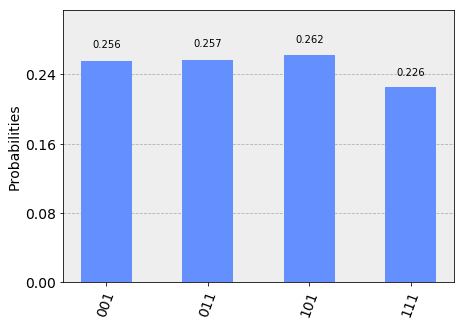

In [19]:
circ_inv.measure(q3, c3)
job = execute(circ_inv , backend=backend)
st = job.result().get_counts()
plot_histogram(st)

If we run the inverted circuit, we can find that we will not end up with the inverted bit string nor with negated one. Analyzing the result states we can see that we have got the bitstring `1111`.

Let's see what will happen if we will attach the inverted circuit to the circuit that we were using to initialize the quantum chip.

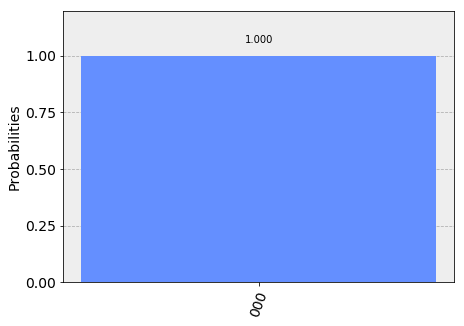

In [20]:
circ = QuantumCircuit(q3, c3)
circ.initialize([0, .5, .5, .0, .5, .0, .0, .5], q3)

circ.barrier()

circ_inv = QuantumCircuit(q3, c3)
circ_inv.initialize([0, .5, .5, .0, .5, .0, .0, .5], q3).inverse()

circ_sum = circ + circ_inv # Concatenation

# Run and plot
circ_sum.measure(q3, c3)
job = execute(circ_sum , backend=backend)
st = job.result().get_counts()
plot_histogram(st)

We get back to the initial state of our qubits. That confirms that the quantum gates works perfectly. If we use a quantum circuit to change the state from the initial state to the desired state, and then we will run a circuit backward we will finish with the initial state.

If we would like to negate the bit string (flip all its bits) we should use a *Pauli X gate* on all of the qubits:

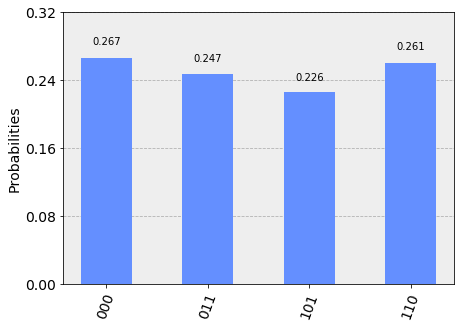

In [21]:
circ = QuantumCircuit(q3, c3)
circ.initialize([0, .5, .5, .0, .5, .0, .0, .5], q3)
circ.x(q3)

# Run and plot
circ.measure(q3, c3)
job = execute(circ , backend=backend)
st = job.result().get_counts()
plot_histogram(st)

Decoding all the bits from the probabilities:

```
   bs | aa v 
  ----|------- 
    0 | 00 0 
    1 | 01 1
    1 | 10 1
    0 | 11 0   
```
we end up, as expected, with `0110`.

## Comparing bit strings

As it was said above if we invert the circuit and act on the desired state then we will go back to the initial state. But what will happen if we use the other inverted circuit? We should receive the initial state only with some probability. We can use this fact to compare similarities of bit strings. The highest probability to get to the initial state is, the more similar bit string should be.

In [22]:
circ = QuantumCircuit(q3, c3)
circ.initialize([0, .5, .5, .0, .5, .0, .0, .5], q3)
circ.barrier()

bs = {'1000': [.0, .5, .5, .0, .5, .0, .5, .0],
      '0110': [.5, .0, .0, .5, .0, .5, .5, .0],
      '1101': [.0, .5, .0, .5, .5, .0, .0, .5],
      '0011': [.5, .0, .5, .0, .0, .5, .0, .5]}

print("Similarity (probability) with 1001:")
for bitstr, ampl in bs.items():
    
    circ_inv = QuantumCircuit(q3, c3)
    circ_inv.initialize(ampl, q3).inverse()
    circ_sum = circ + circ_inv
    circ_sum.measure(q3, c3)
    job = execute(circ_sum , backend=backend, shots=1024)
    st = job.result().get_counts()
    p = st['000'] / 1024 if '000' in st.keys() else 0
    print("%s: %s" % (bitstr, p))

Similarity (probability) with 1001:
1000: 0.5537109375
0110: 0
1101: 0.5537109375
0011: 0.2333984375


If all bits are different (`1001` vs `0110`) then the similarity is 0. If there are three bits in common then the probability is $0.556$. If only two bits are the same then we've got $0.242$.

## Acknowledgments

This tutorial is based upon the "Comparing Strings with Quantum Superposition" tutorial by Rudy Raymond.

I would like to thank James Wootton and Rudy Raymond for their help, extensive explanations, and interesting discussion over the content of this tutorial during [Qiskit Camp ‘19](https://qiskit.camp/).

## References

1. [Comparing Strings with Quantum Superpositon, Rudy Raymond](string_comparison.ipynb)
2. [Qiskit’s documentation - Circuits and Registers](https://qiskit.org/documentation/terra/quantum_circuits.html)
3. [Basic quantum circuit simulation in Python, Jarrod McClean](https://jarrodmcclean.com/basic-quantum-circuit-simulation-in-python/)
4. [Wikipedia - Qubit](https://en.wikipedia.org/wiki/Qubit)
5. [Wikipedia - Quantum logic gate](https://en.wikipedia.org/wiki/Quantum_logic_gate)